# PageRank

#### Librerías utilizadas

In [2]:
import numpy as np
import math
import pandas as pd
from scipy.sparse import csr_matrix 
  
# Para las pruebas
from pytest import approx
import pprint
# Para los grafos
import networkx as nx
import matplotlib.pyplot as plt

## Definimos una set para practicar (por ahora 4 páginas)

Donde podemos observar en la columna `pagina`, la página a la que hace referencia y en la columna `outlinks` que se refiere a los links que esa página hace referencia.

In [3]:
pages_links = pd.DataFrame( columns=['pagina', 'outlinks'])

In [4]:
pages_links['pagina'] = ['A', 'B', 'C', 'D']

In [5]:
pages_links['outlinks'][0] = ['C', 'B']

In [6]:
pages_links['outlinks'][1] = ['D']

In [7]:
pages_links['outlinks'][2] = ['A', 'B', 'D']

In [8]:
pages_links['outlinks'][3] = ['C']

In [9]:
pages_links

,pagina,outlinks
0,A,"[C, B]"
1,B,[D]
2,C,"[A, B, D]"
3,D,[C]


## Definimos un grafo pequeño de acuerdo a los datos anteriores

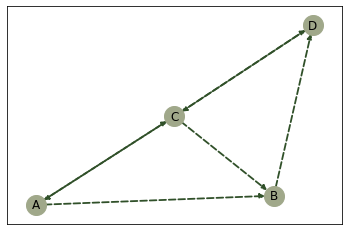

In [10]:
nodos = pages_links['pagina']

G = nx.DiGraph()

for nodo in nodos:
    G.add_node(nodo)
    
for page, outlinks in zip(pages_links['pagina'],pages_links['outlinks']):
    for outlink in outlinks:
        G.add_edge(page, outlink)

pos = nx.spring_layout(G)


nx.draw_networkx_nodes(G, pos, node_color='#a0a88a', node_size=400)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, edge_color='#305029', width=1.8, arrows = True, style='dashed')

plt.show()

### Definimos nuestra matriz estocástica conforme a lo visto en el grafo:

In [11]:
sparseMatrix = csr_matrix((len(pages_links), len(pages_links)),  
                          dtype = np.float).toarray() 

In [12]:
newdf = pd.DataFrame(sparseMatrix, columns = pages_links['pagina'], index=pages_links['pagina'])

In [13]:
count = 0
for page, outlinks in zip(pages_links['pagina'],pages_links['outlinks']):
    score = 1/len(outlinks)
    dict_page = {page: np.zeros(len(pages_links))}
    for outlink in outlinks:
        newdf[page][outlink] = score

In [14]:
newdf

pagina,A,B,C,D
pagina,,,,
A,0.0,0.0,0.333333,0.0
B,0.5,0.0,0.333333,0.0
C,0.5,0.0,0.000000,1.0
D,0.0,1.0,0.333333,0.0


In [15]:
H = newdf.to_numpy()

In [16]:
pd.DataFrame(newdf)

pagina,A,B,C,D
pagina,,,,
A,0.0,0.0,0.333333,0.0
B,0.5,0.0,0.333333,0.0
C,0.5,0.0,0.000000,1.0
D,0.0,1.0,0.333333,0.0


## Aplicamos GoogleMatrix

La matriz que regresa la función representa la matriz de transición que describe la cadena de Markov utilizada en PageRank. Para que el PageRank converga a una única solución, la matriz de transición debe de ser irreducible y estocástica. En otras palabras, Debe existir un camino entre cada uno de los nodos en el grafo, ---or else there is the potential of “rank sinks.”---

Esta función trabaja con Multi(Di)Graphs. Para multigraphs el peso entre dos nodos debe ser la suma de todos los pesos de los edges entre esos nodos.

In [17]:
from networkx.algorithms.link_analysis.pagerank_alg import google_matrix

In [18]:
matrix = google_matrix(G, nodelist=nodos)

In [19]:
A = matrix.T

In [20]:
pprint.pprint(A)

matrix([[0.0375    , 0.0375    , 0.32083333, 0.0375    ],
        [0.4625    , 0.0375    , 0.32083333, 0.0375    ],
        [0.4625    , 0.0375    , 0.0375    , 0.8875    ],
        [0.0375    , 0.8875    , 0.32083333, 0.0375    ]])


## Lo probamos con QR (el que realizamos en la práctica 2)

In [21]:
def sign(x):
    """
    Helper function for computing sign of real number x.
    """
    if x >= 0:
        return 1
    else:
        return -1

In [22]:
def inverse_matrix(A):
    """
    Helper function for computing the inverse of matrix A nxn.
    """
    inv_temp = []
    
    for i in range (0,A.shape[0]): 
        e1 = np.zeros((A.shape[0],1))
        e1[i] = 1
        A_inv_i = np.linalg.solve(A.T, e1)
        inv_temp.append(A_inv_i)  
        
    for j in range (0,len(inv_temp)-1):
        if j == 0:
            r_inv = np.row_stack((inv_temp[j].T, inv_temp[j+1].T))
        else:
            r_inv = np.row_stack((r_inv, inv_temp[j+1].T))
        
    return(r_inv)

In [23]:
def off(T):
    """
    Helper function for computing off(T).
    """
    mask = np.ones(T.shape, dtype = bool)
    np.fill_diagonal(mask, 0)
    T_sin_dig = T[mask]
    sum = 0
    for i in range (0,len(T_sin_dig)):
        # print (T_sin_dig[i])
        sum += T_sin_dig[i]**2
    off_T = np.sqrt(sum)
    
    return(off_T)

In [24]:
def QR_Householder(A):
    """
    Decompose a real square matrix A where: A = QR usign Householder reflections.
    Args:
        A (numpy ndarray): Matrix in which QR algorithm will be performed.
    Returns:
        Q (numpy ndarray): orthogonal matrix (its columns are orthogonal unit vectors meaning 
                           Q.T*Q = Q*Q.T = I)
        R (numpy ndarray): upper triangular matrix.
    """
        
    a_aux = []
            
    for j in range (0,A.shape[0]-1):          #Asumimos que A SIEMPRE será cuadrada
        e = np.zeros((A.shape[0]-j, 1))
        e[0] = 1
        if j == 0:
            v = A[:,0] + sign(A[0,0])*np.linalg.norm(A[:,0])*e.T[0]
            beta = 2/v.dot(v)
            aux = A[:,0:] - beta*np.outer(v,v.dot(A[:,0:]))
            a_aux.append(aux)
        else:
            v = aux[1:,1] + sign(aux[1,1])*np.linalg.norm(aux[1:,1])*e.T[0]
            beta = 2/v.dot(v)  
            aux = aux[1:,1:] - beta*np.outer(v,v.dot(aux[1:,1:]))
            a_aux.append(aux)
        
    n,n = A.shape
    count = 0
    
    if n == 2:
        R = a_aux[0]
    else:
        for h in range(n-2,0,-1):
            if count == 0:
                temp_col = np.column_stack((np.zeros(2 + count), a_aux[h]))
            else:
                temp_col = np.column_stack((np.zeros(2 + count), temp_row))
            temp_row = np.row_stack((a_aux[h-1][0, 0:], temp_col))
            count += 1
        R = temp_row
    R_inv = inverse_matrix(R)
    
    Q = A@R_inv   

    return (Q,R)

In [25]:
def Eig_Householder(A):
    """
    Compute QR algorithm usign Householder reflections multiple times to approximate eigenvalues and 
    eigenvectors of A.
    Args:
        A (numpy ndarray): Symmetric matrix 
    Returns:
        evalues (numpy ndarray): Array with eigenvalues of matrix A.
        evectors (numpy ndarray): Matrix with eigenvectors of matrix A on its columns.
    """
    tol = 10e-8
    max_iters = 1000
    tk_fro_norm = np.linalg.norm(A, 'fro')
    iterations = 0
    off_Tk = off(A)
    
    q_aux = []
    
    while off_Tk > tol*tk_fro_norm and iterations < max_iters:
        iterations += 1
        if iterations == 1:
            Tk_minus1 = A
        else:
            Tk_minus1 = Tk
        
        q,r = QR_Householder(Tk_minus1)    
        q_aux.append(q)
        
        Tk = r@q
        
        off_Tk = off(Tk)
        tk_fro_norm = np.linalg.norm(Tk, 'fro')
    
    #Multiplicación Q0*Q1...Qn para cálculo de eigenvectores
    for g in range(0,len(q_aux)-1,1):
        if g == 0:
            q_temp = q_aux[g]@q_aux[g+1]
        else:
            q_temp = q_temp@q_aux[g+1]
    
    if iterations == 0:
        evalues = "error"
        evectors = "error"
    else:
        evectors = q_temp
        evalues = np.diag(Tk)
    
    return (evalues,evectors)

In [26]:
q, r = QR_Householder(H)

In [27]:
pd.DataFrame(q)

,0,1,2,3
0,0.000000,0.0,8.164966e-01,5.773503e-01
1,-0.707107,0.0,4.082483e-01,-5.773503e-01
2,-0.707107,0.0,-4.082483e-01,5.773503e-01
3,0.000000,-1.0,-8.317231e-18,4.196549e-17


In [28]:
pd.DataFrame(r)

,0,1,2,3
0,-0.707107,0.0,-2.357023e-01,-0.707107
1,0.000000,-1.0,-3.333333e-01,0.000000
2,0.000000,0.0,4.082483e-01,-0.408248
3,0.000000,0.0,1.387779e-17,0.577350


In [29]:
eigval, eigvec = Eig_Householder(H)

In [30]:
pd.DataFrame(eigval)

,0
0,1.000000
1,-0.626538
2,-0.382056
3,0.008595


In [31]:
pd.DataFrame(eigvec)

,0,1,2,3
0,0.232495,0.529635,-0.047676,0.814346
1,0.348743,0.192872,-0.874578,-0.276209
2,0.697486,-0.672574,0.053553,0.241433
3,0.581238,0.479512,0.479553,-0.449732


#### No olvidemos comprobar que los eigenvalores y eigenvectores sean los esperados

#### QR:

In [32]:
q_linalg, r_linalg = np.linalg.qr(A)

In [33]:
pd.DataFrame(q_linalg)

,0,1,2,3
0,-0.057145,0.035604,0.824230,-0.562239
1,-0.704794,-0.041887,0.366354,0.606049
2,-0.704794,-0.041887,-0.430580,-0.562239
3,-0.057145,0.997609,-0.032113,0.021905


In [34]:
pd.DataFrame(r_linalg)

,0,1,2,3
0,-0.65622,-0.105719,-0.289219,-0.656220
1,0.00000,0.883571,0.316480,0.000000
2,0.00000,0.000000,0.355529,-0.338697
3,0.00000,0.000000,0.000000,-0.496522


#### Eigenvalores y eigenvectores:

In [35]:
eigval_eig , eigvec_eig = np.linalg.eig(H)

In [36]:
pd.DataFrame(eigval_eig)

,0
0,1.000000+0.000000j
1,-0.626538+0.000000j
2,-0.186731+0.480774j
3,-0.186731-0.480774j


In [37]:
pd.DataFrame(eigvec_eig)

,0,1,2,3
0,-0.232495+0.000000j,0.445747+0.000000j,0.146497+0.377184j,0.146497-0.377184j
1,-0.348743+0.000000j,0.090025+0.000000j,0.435929+0.112414j,0.435929-0.112414j
2,-0.697486+0.000000j,-0.837833+0.000000j,-0.626088+0.000000j,-0.626088-0.000000j
3,-0.581238+0.000000j,0.302061+0.000000j,0.043661-0.489599j,0.043661+0.489599j


## Probamos con el método de la potencia

El método de la potencia se define como: 
    
$$ PR_{t+1} = H PR_t $$

siendo H la matriz estocástica

##### Definimos un vector inicial 

El vector será de tamaño n, siendo el número de nodos y la inicialización de cada valor será 1/n

En este caso:

\begin{align}
    v &= \begin{bmatrix}
           1/4 \\
           1/4 \\
           1/4 \\
           1/4
         \end{bmatrix}
  \end{align}

In [38]:
v = np.ones(len(pages_links))

In [39]:
v = v*1/len(v)

In [40]:
pprint.pprint(v)

array([0.25, 0.25, 0.25, 0.25])


Para obtener el segundo vector se debe hacer:
    
$$v_2 = Hv$$

In [41]:
v_2 = H@v

pprint.pprint(v_2)

array([0.08333333, 0.20833333, 0.375     , 0.33333333])


Para obtener el tercer vector:
    
$$ v_3 = Hv_2 = H(Hv) = H^2v$$

In [42]:
v_3  = H@v_2

pprint.pprint(v_3)

array([0.125     , 0.16666667, 0.375     , 0.33333333])


In [43]:
v_3_r = (H@H)@v

pprint.pprint(v_3_r)

array([0.125     , 0.16666667, 0.375     , 0.33333333])


Entonces para $$v_n = H^{n-1}v$$

Si iteramos varias veces tiene a un valor equilibrado:

In [44]:
n = 20
H = np.linalg.matrix_power(H, n)
v_n = H@v

In [45]:
v_n

array([0.12500368, 0.18750089, 0.37499297, 0.31250246])

In [46]:
df = pd.DataFrame(v_n, columns=['pagerank'])

In [47]:
df['nodo'] = nodos

In [48]:
df = df.set_index('nodo')

In [49]:
power_method = df.pagerank.to_dict()

In [50]:
power_method

{'A': 0.1250036838777434,
 'B': 0.18750089306127105,
 'C': 0.37499296714248953,
 'D': 0.3125024559184955}

In [51]:
power_method_round = {}    
for node in power_method:
    if node in power_method:
        #set the node name as the key and the label as its value 
        power_method_round[node] = round(power_method[node],2)

In [52]:
power_method_round

{'A': 0.13, 'B': 0.19, 'C': 0.37, 'D': 0.31}

## Intentamos con PageRank de `Networkx`

The eigenvector calculation is done by the power iteration method and has no guarantee of convergence. The iteration will stop after an error tolerance of len(G) * tol has been reached. If the number of iterations exceed max_iter, a networkx.exception.PowerIterationFailedConvergence exception is raised.

The PageRank algorithm was designed for directed graphs but this algorithm does not check if the input graph is directed and will execute on undirected graphs by converting each edge in the directed graph to two edges.

In [53]:
from networkx.algorithms.link_analysis.pagerank_alg import pagerank

In [54]:
pr = pagerank(G, max_iter=20)

In [55]:
pr

{'A': 0.13867229558179425,
 'B': 0.1976082981211456,
 'C': 0.3570799577952133,
 'D': 0.30663944850184677}

In [56]:
pagerank_round = {}    
for node in pr:
    if node in pr:
        #set the node name as the key and the label as its value 
        pagerank_round[node] = round(pr[node],2)

In [57]:
pagerank_round

{'A': 0.14, 'B': 0.2, 'C': 0.36, 'D': 0.31}

## Comparamos método de la potencia vs `pagerank_alg.pagerank`

In [58]:
assert pagerank_round == approx(power_method_round, rel=1e-1)

## Mismo grafo con el  PageRank obtenido por el método de la potencia

{'A': 'A:0.13', 'B': 'B:0.19', 'C': 'C:0.37', 'D': 'D:0.31'}


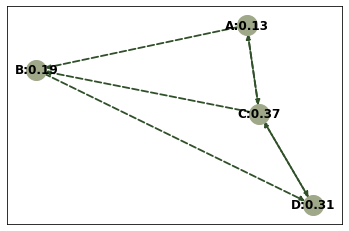

In [59]:
G = nx.DiGraph()

for nodo in power_method:
    G.add_node(nodo)

for page, outlinks in zip(pages_links['pagina'],pages_links['outlinks']):
    for outlink in outlinks:
        G.add_edge(page, outlink)

pos = nx.spring_layout(G)

labels = {}    
for node in G.nodes():
    if node in power_method:
        #set the node name as the key and the label as its value 
        labels[node] = "{}:{}".format(node,round(power_method[node],2))

# Es lo mismo que power_method pero redondeado        
print(labels)

nx.draw_networkx_nodes(G, pos, node_color='#a0a88a', node_size=400)
nx.draw_networkx_labels(G, pos, labels=labels, font_weight="bold")
nx.draw_networkx_edges(G, pos, edge_color='#305029', width=1.8, arrows = True, style='dashed')

plt.show()

Entonces podemos observar que la página con mayor puntuación es la `C`.

## Ahora intentaremos con otro set de datos (37 páginas)

[set de datos de Stanford](http://snap.stanford.edu/data/web-Stanford.html)

In [60]:
path = "../data/web-Stanford.txt"

In [62]:
def read_csv_Stanford(path, nrow=103):
    """
    Read the txt given, only works for web-Stanford 
    """
    df = pd.read_csv(path, nrows=nrow)#, usecols=['FromNode', 'ToNode'])
    # Remove the index
    df = df[3:]
    df = df.rename(columns = {'# Directed graph (each unordered pair of nodes is saved once): web-Stanford.txt ': 
                         'FromTo'})
    df[['FromNode','ToNode']] = df.FromTo.str.split('\t',expand=True) 
    df = df.drop('FromTo', axis=1)
    return df

In [63]:
df_stanford = read_csv_Stanford(path,103)

In [64]:
df_stanford

,FromNode,ToNode
3,1,6548
4,1,15409
5,6548,57031
6,15409,13102
7,2,17794
...,...,...
98,74361,226411
99,74361,239874
100,74361,255694
101,74361,264216


In [65]:
def transform_data():
    """
    Transform the nodes that are not in the FromNode and ToNode match
    This only works for 103 nrows
    """
    missing_from = list(set(df_stanford['FromNode']) - set(df_stanford['ToNode']) )
    missing_to = list(set(df_stanford['ToNode'])  - set(df_stanford['FromNode']) )
    mitad = int(len(missing_to)/2)
    for val in missing_to[:mitad]:
        df_stanford['ToNode'][df_stanford['ToNode'] == val] = missing_from[0]
    for val in missing_to[mitad:]:
        df_stanford['ToNode'][df_stanford['ToNode'] == val] = missing_from[1]

In [66]:
transform_data()

In [67]:
# Hacemos una agrupación y la lista de los outlinks
paginas_stanford = df_stanford.groupby('FromNode').aggregate(lambda tdf: tdf.unique().tolist()).reset_index()

In [68]:
paginas_stanford = paginas_stanford.rename(columns={'FromNode': 'pagina',
                                                    'ToNode': 'outlinks'})

In [69]:
paginas_stanford.head(10)

,pagina,outlinks
0,1,"[6548, 15409]"
1,100193,[2]
2,102355,[2]
3,105318,[2]
4,105730,"[2, 3]"
5,115926,[2]
6,140864,[2]
7,15409,[3]
8,163550,[2]
9,164599,[2]


In [79]:
paginas_stanford.shape

(37, 2)

In [103]:
def plot_node_graph(dataframe_pages, power_method=None, with_labels=False):
    """
    Plotea el grafo
    :param[in] dataframe_pages: dataframe de nx2
                El dataframe debe contener una columna llamada página y otra llamada outlinks;
                donde outlinks contenga una lista de los outlinks por página
    """
    nodos = dataframe_pages['pagina']

    G = nx.DiGraph()

    for nodo in nodos:
        G.add_node(nodo)

    for page, outlinks in zip(dataframe_pages['pagina'], dataframe_pages['outlinks']):
        for outlink in outlinks:
            G.add_edge(page, outlink)

    pos = nx.spring_layout(G)


    nx.draw_networkx_nodes(G, pos, node_color='#a0a88a', node_size=400)
    if with_labels:
        labels = {}    
        for node in G.nodes():
            if node in power_method:
                #set the node name as the key and the label as its value 
                labels[node] = "{}:{}".format(node,round(power_method[node],2))
        nx.draw_networkx_labels(G, pos, labels=labels, font_weight="bold")
    else:
        nx.draw_networkx_labels(G, pos)
    nx.draw_networkx_edges(G, pos, edge_color='#305029', width=1.8, arrows = True, style='dashed')

    plt.show()
    return G

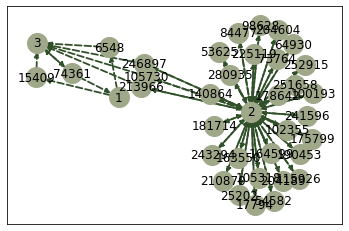

In [104]:
G = plot_node_graph(paginas_stanford)

#### Definimos nuestra matriz estocástica

In [74]:
def get_h_matrix(dataframe_pages):
    """
    Obtiene la matriz H, la matriz estocástica
    :param[in] dataframe_pages: dataframe de nx2
                El dataframe debe contener una columna llamada página y otra llamada outlinks;
                donde outlinks contenga una lista de los outlinks por página
    """
    sparseMatrix = csr_matrix((len(dataframe_pages), len(dataframe_pages)),  
                          dtype = np.float).toarray() 
    newdf = pd.DataFrame(sparseMatrix, columns = dataframe_pages['pagina'], index=dataframe_pages['pagina'])
    count = 0
    for page, outlinks in zip(dataframe_pages['pagina'],dataframe_pages['outlinks']):
        score = 1/len(outlinks)
        dict_page = {page: np.zeros(len(dataframe_pages))}
        for outlink in outlinks:
            newdf[page][outlink] = score
    H = newdf.to_numpy()
    return H

In [75]:
H = get_h_matrix(paginas_stanford)

In [78]:
H.shape

(37, 37)

### Obtenemos pagerank por el método de la potencia

In [82]:
def power_method_pagerank(dataframe_pages, H, iteraciones):
    """
    Obtiene el pagerank 
    :param[in] dataframe_pages: dataframe de nx2
                El dataframe debe contener una columna llamada página y otra llamada outlinks;
                donde outlinks contenga una lista de los outlinks por página
    :param[in] H: Matriz estocástica
    :param[in] iteraciones: número de iteraciones a realizar
    
    :return power_method: Un diccionario con la página como llave y el pagerank como valor
    """
    # Obtenemos nuestro vector inicial
    v = np.ones(len(dataframe_pages))
    v = v*1/len(v)
    
    # Iteramos
    H = np.linalg.matrix_power(H, iteraciones)
    v_n = H@v
    
    # Convertimos a dataframe
    df = pd.DataFrame(v_n, columns=['pagerank'])
    
    df['nodo'] = dataframe_pages['pagina']
    
    df = df.set_index('nodo')
    
    power_method = df.pagerank.to_dict()
    
    return power_method

In [83]:
power_method_dictionary = power_method_pagerank(paginas_stanford, H, iteraciones=100)

In [84]:
power_method_dictionary

{'1': 0.02624731619521057,
 '100193': 0.002263676608499178,
 '102355': 0.002263676608499178,
 '105318': 0.002263676608499178,
 '105730': 0.002263676608499178,
 '115926': 0.002263676608499178,
 '140864': 0.002263676608499178,
 '15409': 0.14106763525999932,
 '163550': 0.002263676608499178,
 '164599': 0.002263676608499178,
 '175799': 0.002263676608499178,
 '17794': 0.002263676608499178,
 '178642': 0.002263676608499178,
 '181714': 0.002263676608499178,
 '190453': 0.002263676608499178,
 '2': 0.0022636766084990997,
 '204189': 0.002263676608499178,
 '204604': 0.002263676608499178,
 '210870': 0.002263676608499178,
 '213966': 0.002263676608499178,
 '225119': 0.002263676608499178,
 '241596': 0.002263676608499178,
 '243294': 0.002263676608499178,
 '246897': 0.002263676608499178,
 '251658': 0.002263676608499178,
 '25202': 0.002263676608499178,
 '252915': 0.002263676608499178,
 '280935': 0.002263676608499178,
 '3': 0.052570088277371085,
 '53625': 0.002263676608499178,
 '54582': 0.002263676608499178

In [86]:
# Redondeamos a 2 dígitos
power_method_round = {}    
for node in power_method_dictionary:
    if node in power_method_dictionary:
        #set the node name as the key and the label as its value 
        power_method_round[node] = round(power_method_dictionary[node],2)

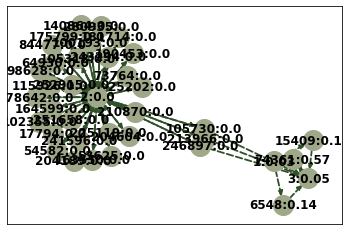

In [105]:
G = plot_node_graph(paginas_stanford, power_method=power_method_round, with_labels=True)

No se puede apreciar pero:

In [107]:
MaxKey = max(power_method_round, key=power_method_round.get)

In [112]:
print("la página con más rank es: {} con un rank de {}".format(MaxKey,power_method_round[MaxKey]))

la página con más rank es: 74361 con un rank de 0.57


## Referencias

- [Google Matrix](https://networkx.org/documentation/stable//reference/algorithms/generated/networkx.algorithms.link_analysis.pagerank_alg.google_matrix.html#networkx.algorithms.link_analysis.pagerank_alg.google_matrix)
- [Código QR](https://github.com/optimizacion-2020-2-gh-classroom/practica-1-segunda-parte-graph-caroacostatovany)
- [PageRank](https://networkx.org/documentation/stable//reference/algorithms/generated/networkx.algorithms.link_analysis.pagerank_alg.pagerank.html)
- [Etiquetas para los nodos](https://stackoverflow.com/questions/14665767/networkx-specific-nodes-labeling)
- [set de datos de Stanford](http://snap.stanford.edu/data/web-Stanford.html)